In [5]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy.integrate import quad

Poisson(μ=76): mean=72.00, std=8.49
Poisson(μ=84): mean=84.00, std=9.17

PDF arrays shape: (200,)
Sum of PDF_76: 1.000000
Sum of PDF_84: 1.000000


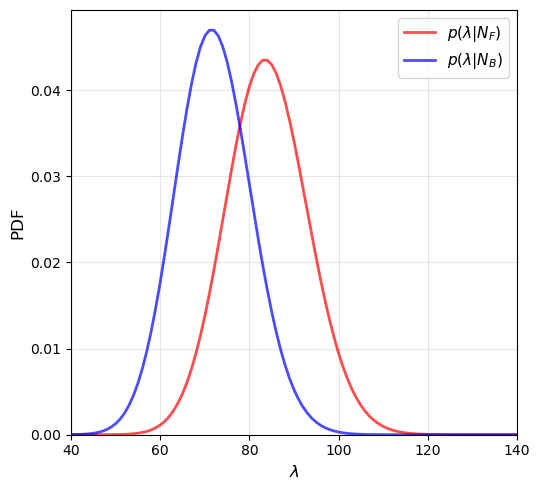

In [8]:
# Define Poisson distributions with means 76 and 84
poisson_76 = poisson(mu=72)
poisson_84 = poisson(mu=84)

# Create k array from 1 to 200
k_array = np.arange( 1, 201,1)

# Compute PDFs for both distributions
pdf_76 = poisson_76.pmf(k_array)
pdf_84 = poisson_84.pmf(k_array)

# Print some statistics
print(f"Poisson(μ=76): mean={poisson_76.mean():.2f}, std={poisson_76.std():.2f}")
print(f"Poisson(μ=84): mean={poisson_84.mean():.2f}, std={poisson_84.std():.2f}")
print(f"\nPDF arrays shape: {pdf_76.shape}")
print(f"Sum of PDF_76: {pdf_76.sum():.6f}")
print(f"Sum of PDF_84: {pdf_84.sum():.6f}")

# Plot the PDFs
plt.figure(figsize=(5.5, 5))

plt.plot(k_array, pdf_84, 'r-', label=r'$p(\lambda|N_F)$', linewidth=2, alpha=0.7)
plt.plot(k_array, pdf_76, 'b-', label=r'$p(\lambda|N_B)$', linewidth=2, alpha=0.7)

plt.xlabel(r'$\lambda$', fontsize=12)
plt.ylabel('PDF', fontsize=12)
# plt.title('Poisson Distribution PDFs', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(40, 140)
plt.ylim(0)
plt.tight_layout()
plt.savefig('Poisson_distribution_pdfs.pdf',bbox_inches='tight')
plt.show()



BAYES FACTOR COMPUTATION FOR ISOTROPY TEST
Observed events - Forward hemisphere (N_F): 84
Observed events - Backward hemisphere (N_B): 72
Total events: 156

Prior: Uniform on λ ∈ [1, 100]

Evidence for H_I (isotropy): 2.033974e-04 ± 2.805051e-12
Evidence for H_A (anisotropy): 9.596516e-05 ± 7.624942e-15

Bayes Factor B^I_A = p(H_I|d) / p(H_A|d) = 2.119492

INTERPRETATION:
B^I_A = 2.12 > 1: Data favors ISOTROPY hypothesis (H_I)
Evidence is 2.12 times stronger for isotropy than anisotropy

Log Bayes Factor: log(B^I_A) = 0.7512

Sigma Significance: 1.226σ (for rejecting anisotropy hypothesis H_A)


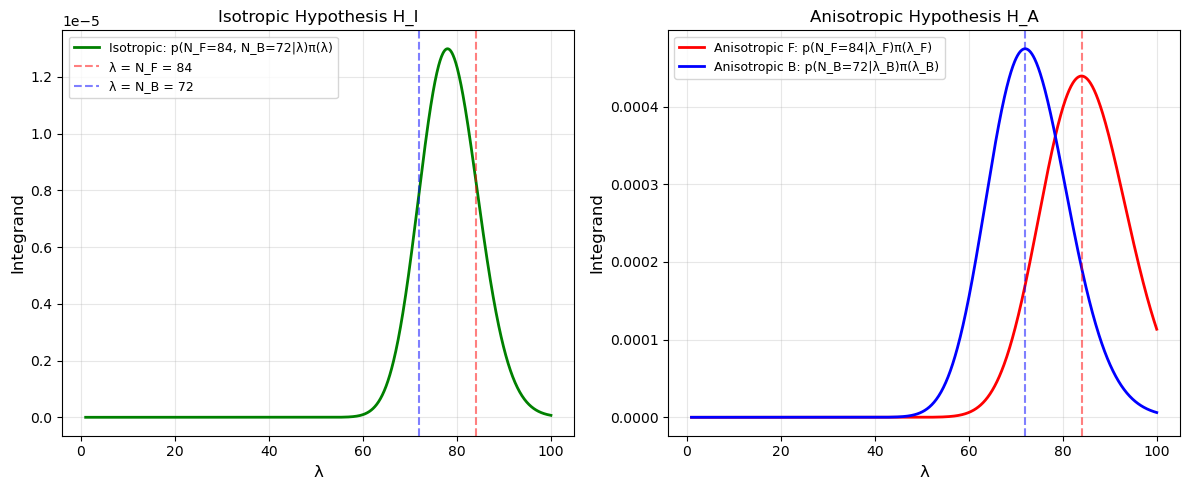

In [10]:
def compute_bayes_factor_isotropy(N_F, N_B, lambda_min=1, lambda_max=100):
    """
    Compute Bayes factor for testing isotropy hypothesis.
    
    H_I (isotropy): Both hemispheres have same Poisson rate λ
    H_A (anisotropy): Each hemisphere has independent rates λ_F and λ_B
    
    Parameters:
    -----------
    N_F : int
        Number of events in Forward hemisphere
    N_B : int
        Number of events in Backward hemisphere
    lambda_min : float
        Lower bound of uniform prior (default: 1)
    lambda_max : float
        Upper bound of uniform prior (default: 100)
    
    Returns:
    --------
    B_IA : float
        Bayes factor B^I_A = p(H_I|d) / p(H_A|d)
    evidence_I : float
        Evidence for isotropic hypothesis
    evidence_A : float
        Evidence for anisotropic hypothesis
    """
    
    # Uniform prior normalization constant
    prior_norm = 1.0 / (lambda_max - lambda_min)
    
    # ===== NUMERATOR: Isotropic hypothesis H_I =====
    # p(H_I|d) = ∫ p(N_F, N_B | λ) π(λ) dλ
    # where p(N_F, N_B | λ) = Poisson(N_F | λ) × Poisson(N_B | λ)
    
    def likelihood_isotropic(lambda_val):
        """Likelihood for isotropic model: p(N_F, N_B | λ)"""
        if lambda_val <= 0:
            return 0.0
        # Poisson likelihood: λ^k * exp(-λ) / k!
        # For two independent Poisson: p(N_F, N_B | λ) = p(N_F | λ) × p(N_B | λ)
        log_likelihood = (N_F + N_B) * np.log(lambda_val) - 2 * lambda_val
        # Subtract log factorials (using Stirling approximation for large numbers if needed)
        log_factorial_F = np.sum(np.log(np.arange(1, N_F + 1))) if N_F > 0 else 0
        log_factorial_B = np.sum(np.log(np.arange(1, N_B + 1))) if N_B > 0 else 0
        return np.exp(log_likelihood - log_factorial_F - log_factorial_B)
    
    def integrand_I(lambda_val):
        """Integrand for isotropic evidence: p(N_F, N_B | λ) × π(λ)"""
        return likelihood_isotropic(lambda_val) * prior_norm
    
    evidence_I, error_I = quad(integrand_I, lambda_min, lambda_max)
    
    # ===== DENOMINATOR: Anisotropic hypothesis H_A =====
    # p(H_A|d) = ∫∫ p(N_F | λ_F) p(N_B | λ_B) π(λ_F) π(λ_B) dλ_F dλ_B
    
    def likelihood_anisotropic_F(lambda_F):
        """Likelihood for Forward hemisphere: p(N_F | λ_F)"""
        if lambda_F <= 0:
            return 0.0
        log_likelihood = N_F * np.log(lambda_F) - lambda_F
        log_factorial_F = np.sum(np.log(np.arange(1, N_F + 1))) if N_F > 0 else 0
        return np.exp(log_likelihood - log_factorial_F)
    
    def likelihood_anisotropic_B(lambda_B):
        """Likelihood for Backward hemisphere: p(N_B | λ_B)"""
        if lambda_B <= 0:
            return 0.0
        log_likelihood = N_B * np.log(lambda_B) - lambda_B
        log_factorial_B = np.sum(np.log(np.arange(1, N_B + 1))) if N_B > 0 else 0
        return np.exp(log_likelihood - log_factorial_B)
    
    # Since the integrals are separable, we can compute them separately
    def integrand_A_F(lambda_F):
        return likelihood_anisotropic_F(lambda_F) * prior_norm
    
    def integrand_A_B(lambda_B):
        return likelihood_anisotropic_B(lambda_B) * prior_norm
    
    evidence_A_F, error_A_F = quad(integrand_A_F, lambda_min, lambda_max)
    evidence_A_B, error_A_B = quad(integrand_A_B, lambda_min, lambda_max)
    
    # Evidence for anisotropic model is the product (since integrals are separable)
    evidence_A = evidence_A_F * evidence_A_B
    
    # Bayes factor
    B_IA = evidence_I / evidence_A if evidence_A > 0 else np.inf
    
    return B_IA, evidence_I, evidence_A, error_I, error_A_F, error_A_B

# Example: Using the means from the Poisson distributions as observed counts
# If we observed N_F = 84 and N_B = 76 events
N_F = 84
N_B = 72

print("=" * 80)
print("BAYES FACTOR COMPUTATION FOR ISOTROPY TEST")
print("=" * 80)
print(f"Observed events - Forward hemisphere (N_F): {N_F}")
print(f"Observed events - Backward hemisphere (N_B): {N_B}")
print(f"Total events: {N_F + N_B}")
print(f"\nPrior: Uniform on λ ∈ [1, 100]")
print("=" * 80)

B_IA, ev_I, ev_A, err_I, err_A_F, err_A_B = compute_bayes_factor_isotropy(N_F, N_B)

print(f"\nEvidence for H_I (isotropy): {ev_I:.6e} ± {err_I:.6e}")
print(f"Evidence for H_A (anisotropy): {ev_A:.6e} ± {err_A_F * ev_A:.6e}")
print(f"\nBayes Factor B^I_A = p(H_I|d) / p(H_A|d) = {B_IA:.6f}")

# Interpretation
print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
if B_IA > 1:
    print(f"B^I_A = {B_IA:.2f} > 1: Data favors ISOTROPY hypothesis (H_I)")
    print(f"Evidence is {B_IA:.2f} times stronger for isotropy than anisotropy")
elif B_IA < 1:
    print(f"B^I_A = {B_IA:.2f} < 1: Data favors ANISOTROPY hypothesis (H_A)")
    print(f"Evidence is {1/B_IA:.2f} times stronger for anisotropy than isotropy")
else:
    print("B^I_A ≈ 1: Data is inconclusive")

# Compute log Bayes factor
log_B_IA = np.log(B_IA)
print(f"\nLog Bayes Factor: log(B^I_A) = {log_B_IA:.4f}")

# Convert Bayes factor to sigma significance
# For BF > 1 (favoring H_I), sigma ≈ sqrt(2 * log(BF)) for rejecting H_A
# For BF < 1 (favoring H_A), sigma ≈ sqrt(2 * log(1/BF)) for rejecting H_I
if B_IA > 1:
    # Favoring isotropy, so significance of rejecting anisotropy
    sigma_significance = np.sqrt(2 * log_B_IA)
    print(f"\nSigma Significance: {sigma_significance:.3f}σ (for rejecting anisotropy hypothesis H_A)")
else:
    # Favoring anisotropy, so significance of rejecting isotropy
    sigma_significance = np.sqrt(2 * np.log(1/B_IA))
    print(f"\nSigma Significance: {sigma_significance:.3f}σ (for rejecting isotropy hypothesis H_I)")

# Plot the integrands as a function of lambda
lambda_range = np.linspace(1, 100, 1000)
# Compute integrands for plotting
integrand_I_vals = np.array([poisson(mu=lam).pmf(N_F) * poisson(mu=lam).pmf(N_B) 
                              for lam in lambda_range])
integrand_A_F_vals = np.array([poisson(mu=lam).pmf(N_F) for lam in lambda_range])
integrand_A_B_vals = np.array([poisson(mu=lam).pmf(N_B) for lam in lambda_range])

prior_norm = 1.0 / 99.0
integrand_I_vals *= prior_norm
integrand_A_F_vals *= prior_norm
integrand_A_B_vals *= prior_norm

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lambda_range, integrand_I_vals, 'g-', linewidth=2, 
         label=f'Isotropic: p(N_F={N_F}, N_B={N_B}|λ)π(λ)')
plt.axvline(N_F, color='r', linestyle='--', alpha=0.5, label=f'λ = N_F = {N_F}')
plt.axvline(N_B, color='b', linestyle='--', alpha=0.5, label=f'λ = N_B = {N_B}')
plt.xlabel('λ', fontsize=12)
plt.ylabel('Integrand', fontsize=12)
plt.title('Isotropic Hypothesis H_I', fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(lambda_range, integrand_A_F_vals, 'r-', linewidth=2, 
         label=f'Anisotropic F: p(N_F={N_F}|λ_F)π(λ_F)')
plt.plot(lambda_range, integrand_A_B_vals, 'b-', linewidth=2, 
         label=f'Anisotropic B: p(N_B={N_B}|λ_B)π(λ_B)')
plt.axvline(N_F, color='r', linestyle='--', alpha=0.5)
plt.axvline(N_B, color='b', linestyle='--', alpha=0.5)
plt.xlabel('λ', fontsize=12)
plt.ylabel('Integrand', fontsize=12)
plt.title('Anisotropic Hypothesis H_A', fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('Bayes_factor_isotropy.pdf', bbox_inches='tight')
plt.show()


## Explanation: Bayes Factor to Sigma Conversion

The conversion formula **σ ≈ √(2 × ln(BF))** comes from the asymptotic relationship between likelihood ratios and chi-squared statistics. Here's how it works:

### 1. **Likelihood Ratio Test (LRT) and Wilks' Theorem**

In frequentist statistics, we compare hypotheses using the **likelihood ratio**:
```
Λ = L(θ₀|data) / L(θ̂|data)
```
where:
- `L(θ₀|data)` = likelihood under the null hypothesis (e.g., isotropy)
- `L(θ̂|data)` = maximum likelihood under the alternative hypothesis (e.g., anisotropy)

**Wilks' Theorem** states that under certain regularity conditions, as sample size → ∞:
```
-2 ln(Λ) ~ χ²(k)
```
where `k` is the difference in the number of free parameters between the two models.

### 2. **Bayes Factor and Likelihood Ratio**

The **Bayes factor** is:
```
BF = p(data|H₀) / p(data|H₁)
```

Under certain conditions (e.g., when priors are relatively flat or when using maximum likelihood estimates), the Bayes factor approximates the likelihood ratio:
```
BF ≈ L(θ₀|data) / L(θ̂|data) = Λ
```

### 3. **Chi-squared to Sigma Conversion**

For a chi-squared distribution with `k` degrees of freedom:
- A `χ²(k)` value corresponds to a certain significance level
- For `k=1` (comparing two models differing by 1 parameter), we have:
  ```
  χ²(1) = σ²
  ```
  where `σ` is the number of standard deviations.

Therefore:
```
-2 ln(BF) ≈ χ²(1) = σ²
```

Solving for σ:
```
σ ≈ √(2 × ln(BF))
```

### 4. **Interpretation**

- **BF > 1**: Data favors H₀ (isotropy). The significance for rejecting H₁ (anisotropy) is `σ = √(2 × ln(BF))`
- **BF < 1**: Data favors H₁ (anisotropy). The significance for rejecting H₀ (isotropy) is `σ = √(2 × ln(1/BF))`

### 5. **Important Caveats**

⚠️ **This conversion is approximate** and relies on:
- Large sample sizes (asymptotic limit)
- Nested models (one hypothesis is a special case of the other)
- Regularity conditions for Wilks' theorem
- Flat or uninformative priors (for BF ≈ likelihood ratio)

For your case with `BF = 2.12`:
- `σ = √(2 × ln(2.12)) = √(2 × 0.751) ≈ 1.23σ`
- This means the evidence against anisotropy is approximately **1.23 standard deviations**, which is **not statistically significant** (typically need > 3σ or > 5σ for strong evidence)


In [11]:
# Numerical demonstration of the relationship
from scipy.stats import chi2

print("=" * 80)
print("NUMERICAL DEMONSTRATION: Bayes Factor ↔ Sigma Conversion")
print("=" * 80)

# For your Bayes factor
BF = B_IA
log_BF = np.log(BF)
sigma_calc = np.sqrt(2 * log_BF)

print(f"\nYour Bayes Factor: BF = {BF:.4f}")
print(f"Log Bayes Factor: ln(BF) = {log_BF:.4f}")
print(f"Calculated Sigma: σ = √(2 × ln(BF)) = {sigma_calc:.4f}σ")

# Show the chi-squared connection
chi2_value = 2 * log_BF
print(f"\nEquivalent χ²(1) value: -2×ln(BF) = {chi2_value:.4f}")

# Convert chi-squared to p-value and then to sigma
p_value = 1 - chi2.cdf(chi2_value, df=1)
print(f"P-value (one-tailed): p = {p_value:.4f}")

# Convert p-value back to sigma (using inverse normal CDF)
from scipy.stats import norm
sigma_from_p = norm.ppf(1 - p_value)
print(f"Sigma from p-value: σ = {sigma_from_p:.4f}σ")

print("\n" + "=" * 80)
print("Comparison Table: BF → Sigma")
print("=" * 80)
print(f"{'Bayes Factor':<15} {'ln(BF)':<12} {'σ (approx)':<15} {'Interpretation'}")
print("-" * 80)

test_BFs = [1.0, 1.5, 2.0, 2.12, 3.0, 5.0, 10.0, 20.0, 100.0]
for bf in test_BFs:
    sig = np.sqrt(2 * np.log(bf)) if bf >= 1 else np.sqrt(2 * np.log(1/bf))
    if bf == 1.0:
        interp = "No evidence"
    elif bf < 3:
        interp = "Weak evidence"
    elif bf < 10:
        interp = "Moderate evidence"
    elif bf < 100:
        interp = "Strong evidence"
    else:
        interp = "Very strong evidence"
    print(f"{bf:<15.2f} {np.log(bf):<12.4f} {sig:<15.3f} {interp}")

print("\nNote: σ values are approximate and valid in the asymptotic limit.")


NUMERICAL DEMONSTRATION: Bayes Factor ↔ Sigma Conversion

Your Bayes Factor: BF = 2.1195
Log Bayes Factor: ln(BF) = 0.7512
Calculated Sigma: σ = √(2 × ln(BF)) = 1.2257σ

Equivalent χ²(1) value: -2×ln(BF) = 1.5024
P-value (one-tailed): p = 0.2203
Sigma from p-value: σ = 0.7711σ

Comparison Table: BF → Sigma
Bayes Factor    ln(BF)       σ (approx)      Interpretation
--------------------------------------------------------------------------------
1.00            0.0000       0.000           No evidence
1.50            0.4055       0.901           Weak evidence
2.00            0.6931       1.177           Weak evidence
2.12            0.7514       1.226           Weak evidence
3.00            1.0986       1.482           Moderate evidence
5.00            1.6094       1.794           Moderate evidence
10.00           2.3026       2.146           Strong evidence
20.00           2.9957       2.448           Strong evidence
100.00          4.6052       3.035           Very strong evidence

No